In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
import torchvision.models as models
import pandas as pd

import os
import numpy as np
import librosa
import os
import torch
import torchaudio.transforms as T
import datetime
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

#import own modules
import config
from utils_dir.utils import *


#empty cache
torch.cuda.empty_cache()
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

###############Dataloader for training the model####################
if config.ADSMI:
    from DL_finetune import ADSMI_DL_finetune as DSf
    Data_name = 'ADSMI'
if config.ESC_50:
    from DL_finetune import ESC_50_DL_finetune as DSf
    Data_name = 'ESC-50'

In [2]:
print(config.channels)

class Resnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_Classifier, self).__init__()

        # Load the pretrained ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=True)

        # Change the first layer to accept 1-channel input (instead of the default 3 channels for RGB)
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify the last fully connected layer to match the number of classes
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)
    


3


In [ ]:

# Hyperparameters
num_epochs = config.epochs
learning_rate = config.lr
weight_decay = 1e-5  # L2 regularization
batch_size = config.batch_size

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Early stopping parameters
patience = config.patience  # This value can be changed based on how many epochs of no improvement you're willing to wait
early_stop_counter = 0

# Initialize dataset and dataloaders
train_loader, test_loader = DSf.create_generators_finetune()

# Initialize the Classifier
num_classes = config.class_numbers
model = Resnet50_Classifier(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Assuming the WarmUpExponentialLR class and config values are available
scheduler = WarmUpExponentialLR(optimizer, cold_epochs= 0, warm_epochs= config.warm_epochs, gamma=config.gamma)  # Adjust warm_epochs and gamma as needed

# Create log directory
current_date = datetime.datetime.now().strftime('%Y-%m-%d-%H')
log_dir = f"./results_standalone/RN_class-{current_date}-epochs-{num_epochs}-{Data_name}"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Log file path
log_file_path = os.path.join(log_dir, "training_log.txt")

#write in log file the hyperparameters
with open(log_file_path, 'a') as log_file:
    log_file.write(f"##############################################################################\n")
    log_file.write(f"Hyperparameters:\n")
    if config.ADSMI:
        log_file.write(f"ADSMI labeled Data\n")
    if config.ESC_50:
        log_file.write(f"ESC-50 labeled Data\n")

    log_file.write(f"num_epochs: {num_epochs}\n")
    log_file.write(f"initial_learning_rate: {learning_rate}\n")
    log_file.write(f"weight_decay: {weight_decay}\n")
    log_file.write(f"batch_size: {batch_size}\n")
    log_file.write(f"patience: {patience}\n")
    log_file.write(f"early_stop_counter: {early_stop_counter}\n")
    log_file.write(f"num_classes: {num_classes}\n")
    #log_file.write(f"model: {model}\n")
    log_file.write(f"criterion: {criterion}\n")
    #log_file.write(f"optimizer: {optimizer}\n")
    #log_file.write(f"scheduler: {scheduler}\n")
    #log_file.write(f"log_dir: {log_dir}\n")
    log_file.write(f"log_file_path: {log_file_path}\n")
    #log_file.write(f"train_loader: {train_loader}\n")
    #log_file.write(f"test_loader: {test_loader}\n")
    log_file.write(f"##############################################################################\n")
# Variables for checkpointing
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for _, (file_name, data, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, labels = data.to(device), labels.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for _, (file_name, data, labels) in tqdm(enumerate(test_loader), total=len(test_loader)):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(test_loader)

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print("Validation Loss improved! Saving the model...")

        # Log to file
        with open(log_file_path, 'a') as log_file:
            log_file.write(f"Validation Loss improved! Saving the model...\n")
        
        torch.save(model, log_dir + '/checkpoint.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping!")
            break

    scheduler.step()  # update the learning rate

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Log to file early stoping counter
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Early stopping counter: {early_stop_counter} from {patience}\n")
    
    # Log to file
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n")
        log_file.write(f"##\n")


In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Initialize dataset and dataloaders
train_loader, test_loader = DSf.create_generators_finetune()

model = torch.load('results_standalone/Cluster_finetune_5h/checkpoint.pth')


def evaluate_model_standalone(test_loader, model):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for (file_name, data, labels) in tqdm(test_loader):
            data, labels = data.to(device), labels.to(device)
            
            outputs = model(data)
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            
    # Calculate accuracy
    correct_preds = sum(t == p for t, p in zip(true_labels, pred_labels))
    accuracy = correct_preds / len(true_labels)

    # Calculate precision, recall, F1-score
    precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

    # Calculate the confusion matrix
    conf_mat = confusion_matrix(true_labels, pred_labels)

    # Print the results
    print(f"\nEvaluation Results:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1_score * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_mat)

# Call the evaluate function after training
evaluate_model_standalone(test_loader, model)


100%|██████████| 10/10 [03:20<00:00, 20.05s/it]


Evaluation Results:
Accuracy: 79.90%
Precision: 80.52%
Recall: 79.90%
F1-score: 79.68%
Confusion Matrix:
[[257  16  16   0]
 [ 21  58   2   1]
 [ 51   2 155   1]
 [  1   6   4  11]]


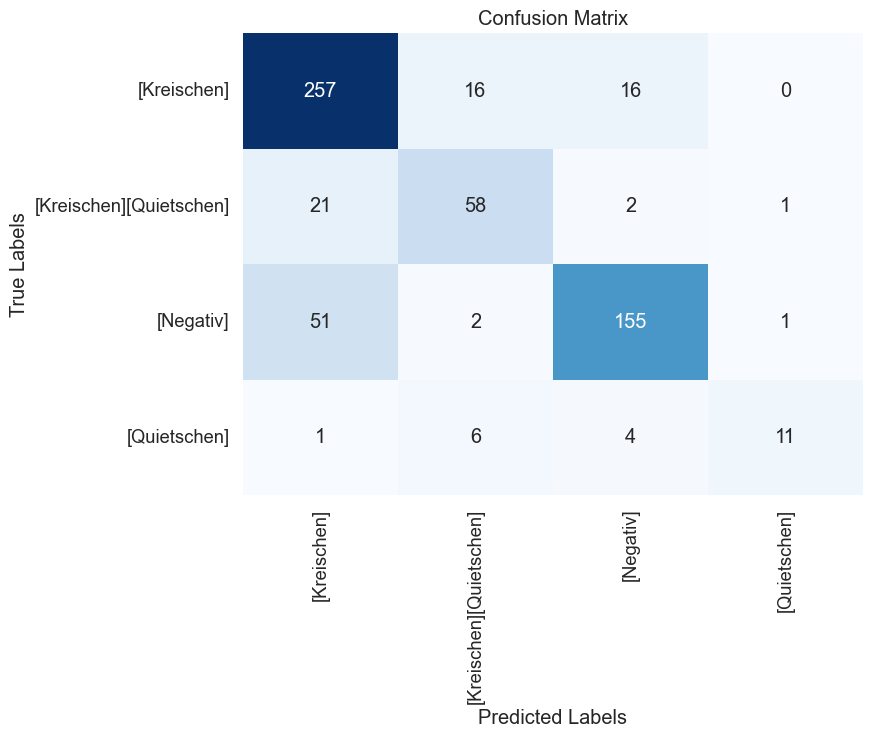

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Initialize dataset and dataloaders
train_loader, test_loader = DSf.create_generators_finetune()

model = torch.load('results_standalone/Cluster_finetune_5h/checkpoint.pth')

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=[true_labels_dic[label] for label in class_labels],
                yticklabels=[true_labels_dic[label] for label in class_labels])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.show()

def evaluate_model_standalone(test_loader, model):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for (file_name, data, labels) in tqdm(test_loader):
            data, labels = data.to(device), labels.to(device)
            
            outputs = model(data)
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            
    # Calculate accuracy
    correct_preds = sum(t == p for t, p in zip(true_labels, pred_labels))
    accuracy = correct_preds / len(true_labels)

    # Calculate precision, recall, F1-score
    precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

    # Calculate the confusion matrix
    conf_mat = confusion_matrix(true_labels, pred_labels)

    # Print the results
    print(f"\nEvaluation Results:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1_score * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_mat)

    # Plot the confusion matrix with labels
    class_labels = sorted(list(set(true_labels)))
    plot_confusion_matrix(conf_mat, class_labels)

# Call the evaluate function after training
evaluate_model_standalone(test_loader, model)
